<a href="https://colab.research.google.com/github/maneesha-bogahawatta/Energy-Demand-Forecasting-ML-TimeSeries/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Analysis and Forecasting with ARIMA**

Load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load the data
data = pd.read_csv("TimeSeries_TotalSolarGen_and_Load_IT_2016.csv")
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


Visuallize the data

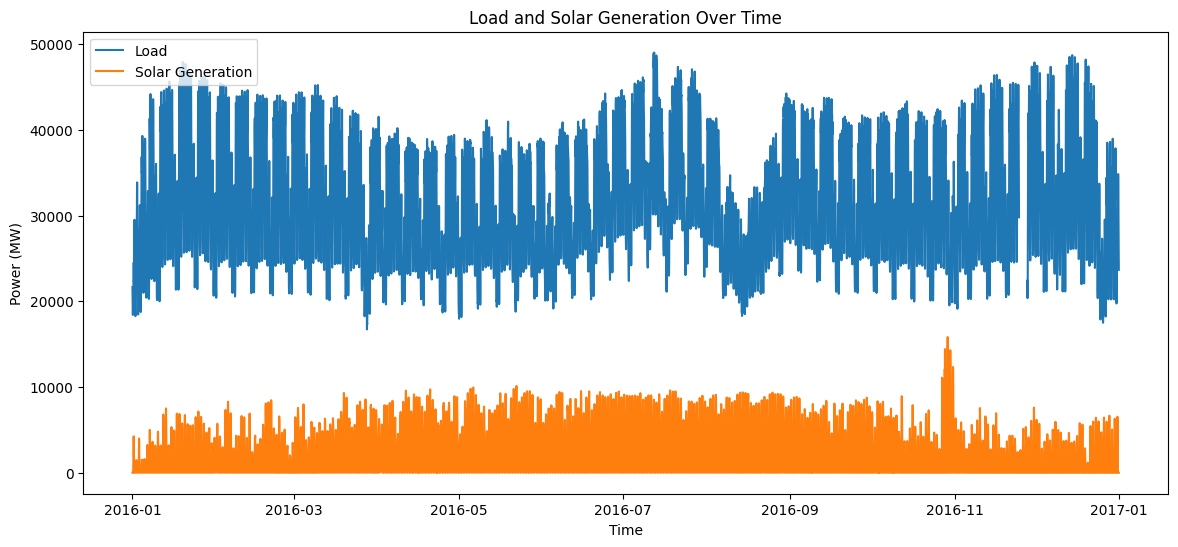

In [2]:
#Convert utc_timestamp to datetime
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

#Plot the data
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'], data['IT_load_new'], label='Load')
plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.title('Load and Solar Generation Over Time')
plt.show()

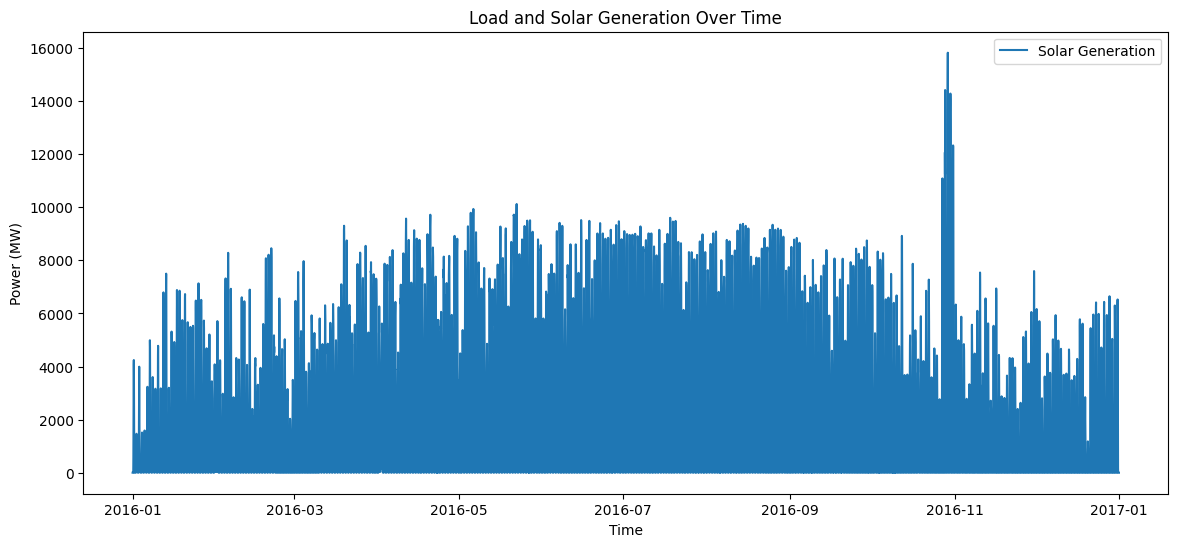

In [3]:
#Plot the data
plt.figure(figsize=(14,6))

plt.plot(data['utc_timestamp'], data['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.title('Load and Solar Generation Over Time')
plt.show()

The plot shows both the load and solar generation over time for 2016. The load appears to have a cyclical patterns with peaks and valleys, possibly corresponding to daily patterns of electricity use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also
appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

Before moving on to time series analysis and forecasting with ARIMA, it's important to check for stationarity in your time series data. Stationarity is a property
of time series data that implies the mean, variance, and autocorrelation structure do not change over time. Many time series models, including ARIMA, require
the data to be stationary.

Let's perform an Augmented Dickey-Fuller test to check the stationarity of the time series. The null hypothesis of the ADF test is that the time series is non-
stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed
stationary.

Handle Missing Values

In [5]:
#check for missing values
data.isnull().sum()

,0
utc_timestamp,0
IT_load_new,72
IT_solar_generation,0


In [13]:
from statsmodels.tsa.stattools import adfuller

# Fill missing values using forward fill
data['IT_load_new'] = data['IT_load_new'].ffill()
data['IT_solar_generation'] = data['IT_solar_generation'].ffill()

# Check for missing values again
print("Missing values after filling")
print(data.isnull().sum())

# Perform Augmented Dickey-Fuller test again
print("\n ADF test for 'IT_load_new' after filling missing values")
print(adfuller(data['IT_load_new']))

print("\n ADF test for 'IT_solar_generation' after filling missing values")
print(adfuller(data['IT_solar_generation']))

Missing values after filling
utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64

 ADF test for 'IT_load_new' after filling missing values
(np.float64(-11.973903805672363), np.float64(3.8414451701510403e-22), 37, 8746, {'1%': np.float64(-3.43109790993778), '5%': np.float64(-2.861870526484161), '10%': np.float64(-2.566945934275714)}, np.float64(138800.81976512843))

 ADF test for 'IT_solar_generation' after filling missing values
(np.float64(-5.7413345822711435), np.float64(6.265438259038232e-07), 36, 8747, {'1%': np.float64(-3.43109782440793), '5%': np.float64(-2.8618704886904087), '10%': np.float64(-2.5669459141578455)}, np.float64(123559.75076633792))


Check for Stationarity

In [12]:
#Function to perform ADF test
def adf_test(timeseries):
    result = adfuller(timeseries)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f"{label}: {value}")
        if result[1] <= 0.05:
            print("The time series is stationary")
            print ("\n")
        else:
            print("The time series is not stationary")
            print ("\n")




In [14]:
# Using the adf_test function for better readability
print("Stationarity test for IT_load_new:")
adf_test(data['IT_load_new'])

print("Stationarity test for IT_solar_generation:")
adf_test(data['IT_solar_generation'])

Stationarity test for IT_load_new:
ADF Test Statistic: -11.973903805672363
The time series is stationary


p-value: 3.8414451701510403e-22
The time series is stationary


#Lags Used: 37
The time series is stationary


Number of Observations Used: 8746
The time series is stationary


Stationarity test for IT_solar_generation:
ADF Test Statistic: -5.7413345822711435
The time series is stationary


p-value: 6.265438259038232e-07
The time series is stationary


#Lags Used: 36
The time series is stationary


Number of Observations Used: 8747
The time series is stationary




**from the Augmented Dickey-Fuller test:**

For 'IT_load_new': The p-value is extremely small (much less than 0.05), so we reject the null hypothesis that the time series is non-stationary. Therefore,
'IT_load_new can be considered stationary.

For 'IT_solar_generation': The p-value is also very small (much less than 0.05), so we reject the null hypothesis. This means 'IT_solar_generation' can be
considered stationary as well.

Since both series are stationary, we can proceed with building an ARIMA model for each of them.



**Build ARIMA model for 'IT_load_new'**

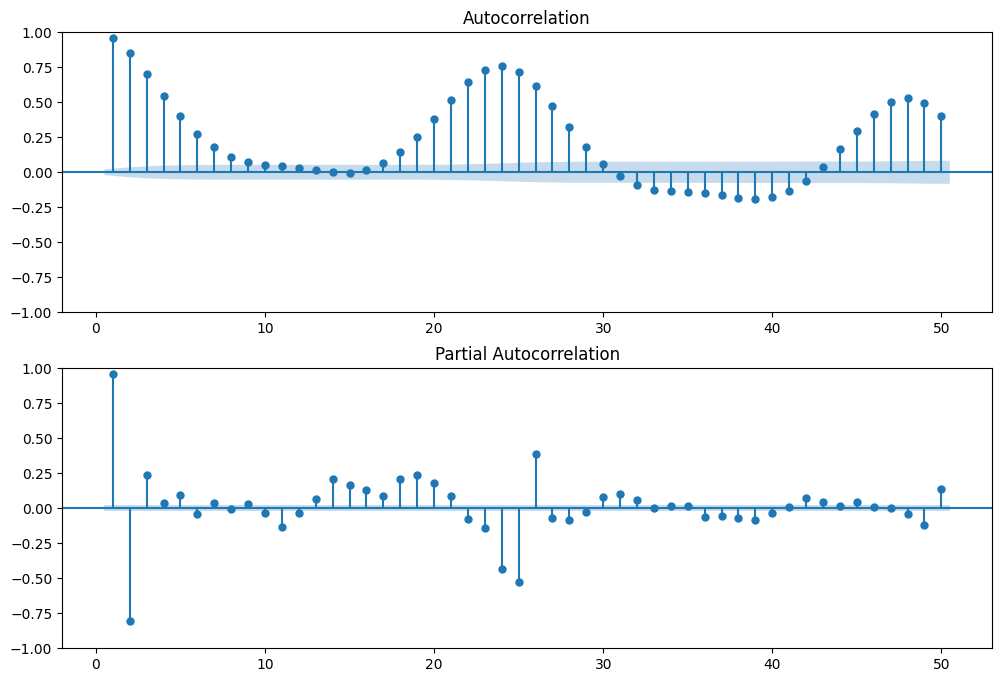

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data['IT_load_new'], lags = 50, zero = False,ax=ax1)
plot_pacf(data['IT_load_new'],lags = 50, zero = False, ax=ax2)
plt.show()

From the ACF plot, we see a gradual decrease, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=2 and q=2 as our model
parameters.

Now let's fit the ARIMA model to our 'IT_load_new' time series. We will use the first 80% of the data for training and the last 20% for testing. This way, we can
evaluate the performance of our model on unseen data.

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

#Split the data into training and test sets
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

#Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

#Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

#Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 7714.952


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [31]:
#Fit the ARIMA model
model2 = ARIMA(train, order=(2,1,2))
model_fit2 = model2.fit()

#Make predictions on the test set
predictions2 = model_fit2.predict(start=len(train), end=len(train)+len(test)-1)

#Calculate RMSE
rmse2 = sqrt(mean_squared_error(test, predictions2))
print('Test RMSE: %.3f' % rmse2)

Test RMSE: 7993.849


In [27]:
#Fit the ARIMA model
model3 = ARIMA(train, order=(2,2,2))
model_fit3 = model3.fit()

#Make predictions on the test set
predictions = model_fit3.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

#Calculate RMSE
rmse3 = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse3)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 9290.389


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


The root mean squared error (RMSE) for the ARIMA model on 'IT_load_new' is approximately 7715. RMSE is a measure of the differences between the values
predicted by a model and the values actually observed. It's a good measure of how accurately the model predicts the response, and it is the most important
criterion for fit if the main purpose of the model is prediction.

However, the value of RMSE itself is not as informative as comparing it to some benchmark, like the standard deviation of the response, or comparing between
different models for the same dataset. Let's plot the actual values and the forecasted values to visualize how well our model is performing

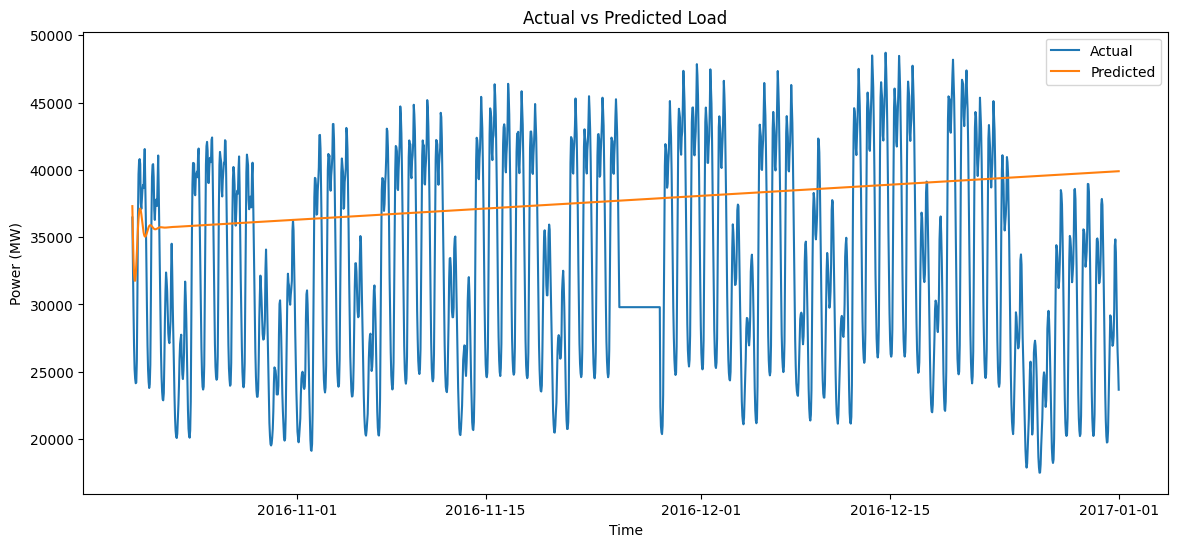

In [28]:
#Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.title('Actual vs Predicted Load')
plt.show()

From the graph, you can conclude:

1️⃣ ARIMA failed to capture the daily and weekly patterns

The actual load (blue line) has strong repeating peaks and valleys (clear seasonality), but the ARIMA prediction (orange line) is almost a flat or slowly increasing straight line.

This means ARIMA did not model the seasonality or short-term variations.

2️⃣ The model underfits the data

The predicted values stay close to the average value of the series instead of following the real fluctuations.
This shows underfitting, meaning ARIMA was too simple for this highly seasonal data.

**SARIMA Model (Seasonal ARIMA)**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

# Re-load data and preprocess to ensure 'data' DataFrame is defined
data = pd.read_csv("TimeSeries_TotalSolarGen_and_Load_IT_2016.csv")
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data['IT_load_new'] = data['IT_load_new'].ffill()
data['IT_solar_generation'] = data['IT_solar_generation'].ffill()

# Split the data into training and test sets (same as ARIMA)
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

# Define SARIMA orders
# Non-seasonal (p,d,q): Using (2,0,2) from the best performing ARIMA model (d=0 as series is stationary)
# Seasonal (P,D,Q,s): Assuming daily seasonality (s=24). D=1 for seasonal differencing, P=1, Q=1 as common starting points.
order = (2,0,2)
seasonal_order = (1,1,1,24) # Daily seasonality (24 hours)

# Fit the SARIMA model
# Increased maxiter for better convergence, and disp=False to suppress detailed iteration output
sarima_model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                     enforce_stationarity=False, enforce_invertibility=False)
sarima_model_fit = sarima_model.fit(disp=False, maxiter=1000)

# Make predictions on the test set
sarima_predictions = sarima_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Calculate RMSE
sarima_rmse = sqrt(mean_squared_error(test, sarima_predictions))
print('SARIMA Test RMSE: %.3f' % sarima_rmse)

# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], sarima_predictions, label='SARIMA Predicted')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.title('Actual vs Predicted Load (SARIMA)')
plt.show()

**DeepAR (Amazon GluonTS)**